# UiBench benchmark on Android

This benchmark is used to evaluate the responsiveness of an Android system to user interaction. Also **systraces** are captured during the benchmark run and represented at the end of the notebook.

In [1]:
import logging

from conf import LisaLogging
LisaLogging.setup()

2018-08-16 14:31:59,834 INFO    : root         : Using LISA logging configuration:
2018-08-16 14:31:59,836 INFO    : root         :   /home/steven/lisa/lisa-github/logging.conf


In [2]:
%pylab inline

import json
import os

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload, System

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import pandas as pd
import sqlite3

Populating the interactive namespace from numpy and matplotlib


## Support Functions

This function helps us run our experiments:

In [3]:
def experiment():
    # Configure governor
    target.cpufreq.set_all_governors('schedutil')
    
    # Get workload
    wload = Workload.getInstance(te, 'UiBench')
        
    # Run UiBench
    wload.run(te.res_dir, test_name='TrivialAnimationActivity', duration_s=10, collect='ftrace')
        
    # Dump platform descriptor
    te.platform_dump(te.res_dir)

## Test environment setup
For more details on this please check out **examples/utils/testenv_example.ipynb**.

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
# Setup target configuration
androidsdk_path=os.path.join(os.getcwd(), "../../../../android-sdk")
my_conf = {

#     # Target platform and board
#     "platform"     : 'android',
#     "board"        : 'pixel',
    
#     # Device
#     "device"       : "FA6A10306347",
    
#     # Android home
#     "ANDROID_HOME" : "/home/vagrant/lisa/tools/android-sdk-linux/",
    
    "platform"    : 'android',
    "board"       : "hikey960",
    "device" : "0123456789ABCDEF",
    
    "ANDROID_HOME" : androidsdk_path,
    "rtapp-calib" : {"0": 302, "1": 302, "2": 304, "3": 304, "4": 136, "5": 137, "6": 136, "7": 136},

     "emeter" : {
        "instrument" : "acme",
        "conf" : {
            # Absolute path to the iio-capture binary on the host
            'iio-capture' : '/usr/bin/iio-capture',
            # Default host name of the BeagleBone Black
#             'ip_address'     : '10.65.34.1',
        },
        "channel_map" : {
            "Device0" : 0, # iio:device0
            "Device1" : 1, # iio:device0
        }
    },

    # Folder where all the results will be collected
    "results_dir" : "UiBench_example",

    # Define devlib modules to load
    "modules"     : [
        'cpufreq'       # enable CPUFreq support
    ],

    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "sched_switch",
            "sched_wakeup",
            "sched_wakeup_new",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "cpu_capacity",
            "cpu_frequency",
         ],
         "buffsize" : 100 * 1024,
    },

    # Tools required by the experiments
    "tools"   : [ 'trace-cmd', 'taskset'],
}

In [5]:
# Initialize a test environment using:
te = TestEnv(my_conf, wipe=False)
target = te.target

2018-08-16 14:32:01,522 INFO    : TestEnv      : Using base path: /home/steven/lisa/lisa-github
2018-08-16 14:32:01,524 INFO    : TestEnv      : Loading custom (inline) target configuration
2018-08-16 14:32:01,528 INFO    : TestEnv      : External tools using:
2018-08-16 14:32:01,530 INFO    : TestEnv      :    ANDROID_HOME: /home/steven/lisa/lisa-github/ipynb/workshop/android/../../../../android-sdk
2018-08-16 14:32:01,532 INFO    : TestEnv      :    CATAPULT_HOME: /home/steven/lisa/lisa-github/tools/catapult
2018-08-16 14:32:01,534 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2018-08-16 14:32:01,535 INFO    : TestEnv      : Connecting Android target [0123456789ABCDEF]
2018-08-16 14:32:01,537 INFO    : TestEnv      : Connection settings:
2018-08-16 14:32:01,539 INFO    : TestEnv      :    {'device': '0123456789ABCDEF'}
2018-08-16 14:32:02,723 INFO    : TestEnv      : Initializing target workdir:
2018-08-16 14:32:02,725 INFO    : TestEnv      :    /data

## Workloads execution

This is done using the **experiment** helper function defined above which is configured to run a **UiBench - TrivialAnimation** experiment.

In [6]:
# Intialize Workloads for this test environment
results = experiment()

2018-08-16 14:32:05,253 INFO    : Workload     : Packages:
['com.android.cts.priv.ctsshim', 'com.android.providers.telephony', 'com.android.providers.calendar', 'com.android.providers.media', 'com.android.wallpapercropper', 'com.android.launcher', 'com.antutu.ABenchMark', 'com.android.documentsui', 'com.android.externalstorage', 'com.android.htmlviewer', 'com.android.quicksearchbox', 'com.android.mms.service', 'com.android.providers.downloads', 'com.primatelabs.geekbench', 'com.antutu.benchmark.full', 'com.android.defcontainer', 'com.android.providers.downloads.ui', 'com.android.pacprocessor', 'com.android.certinstaller', 'android', 'com.android.contacts', 'com.android.camera2', 'com.rovio.angrybirds', 'com.android.egg', 'com.android.mtp', 'com.android.backupconfirm', 'com.android.provision', 'com.android.statementservice', 'com.android.calendar', 'com.android.providers.settings', 'berserker.android.apps.sshdroid', 'com.android.sharedstoragebackup', 'com.android.printspooler', 'com.and

## Benchmarks results

In [7]:
# Benchmark statistics
db_file = os.path.join(te.res_dir, "framestats.txt")
!sed '/Stats since/,/99th/!d;/99th/q' {db_file}

# For all results:
# !cat {results['db_file']}

Stats since: 1722292816403ns
Total frames rendered: 910
Janky frames: 838 (92.09%)
50th percentile: 25ms
90th percentile: 48ms
95th percentile: 61ms
99th percentile: 69ms


## Traces visualisation

For more information on this please check **examples/trace_analysis/TraceAnalysis_TasksLatencies.ipynb**.

In [8]:
# Parse all traces
platform_file = os.path.join(te.res_dir, 'platform.json')
with open(platform_file, 'r') as fh:
    platform = json.load(fh)
trace_file = os.path.join(te.res_dir, 'trace.dat')
trace = Trace(platform, trace_file, events=my_conf['ftrace']['events'])

trappy.plotter.plot_trace(trace.ftrace)

2018-08-16 14:32:56,511 INFO    : Trace        : Platform clusters verified to be Frequency coherent


2018-08-16 14:33:12,423 INFO    : Analysis     : LITTLE cluster average frequency: 1.445 GHz
2018-08-16 14:33:12,424 INFO    : Analysis     : big    cluster average frequency: 1.504 GHz
2018-08-16 14:33:12,426 INFO    : root         : Plotting cluster frequencies for [sched]...


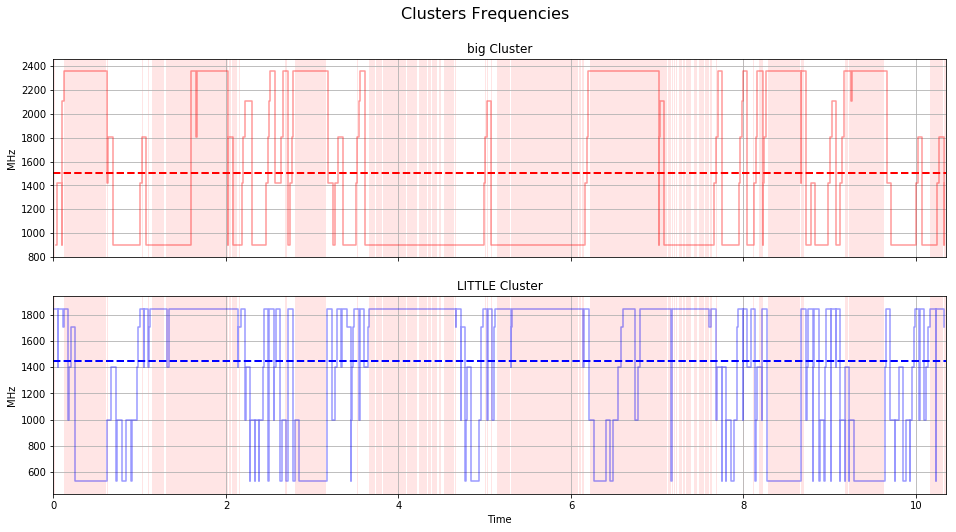

In [9]:
try:
    trace.analysis.frequency.plotClusterFrequencies();
    logging.info('Plotting cluster frequencies for [sched]...')
except: pass